# Degradation example


This juypter notebook is intended to test the degradation analysis workflow.  In addition, the notebook demonstrates the effects of changes in the workflow.

Degradation analysis of PV systems includes several steps:
1. <b>Standardize</b> data inputs
2. <b>Normalize</b> data using a performance metric
3. <b>Filter</b> data that creates bias 
4. <b>Analyze</b> aggregated data to estimate the degradation rate



In [1]:
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import pvlib
%matplotlib inline

#Update the style of plots
import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })

import rdtools


# 1. <b>Standardize</b>

Please download the site data from Site 5, and unzip the csv file in the folder:
./rdtools/docs/

http://dkasolarcentre.com.au/historical-data/download

The following script loads the data, parses a pandas.DateTimeIndex, and renames the critical pandas.Series objects.



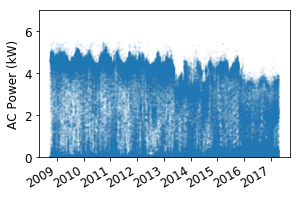

In [2]:
file_name = '89-Site_5-Kyocera.csv'

df_raw = pd.DataFrame.from_csv(file_name, index_col=0, parse_dates=True)

df = pd.DataFrame()
df['ac power'] = df_raw.iloc[:,2]
df['ghor'] = df_raw.iloc[:,8]
df['tamb'] = df_raw.iloc[:,6]

# downsample, degradation_year_on_year does not currently support 5-minute data
df = df.asfreq('15T') 

# plot the AC power time series
fig, ax = plt.subplots()
ax.plot(df.index, df['ac power'], 'o', alpha = 0.1)
ax.set_ylim(0,7)
fig.autofmt_xdate()
ax.set_ylabel('AC Power (kW)');

# 2. <b>Normalize</b> 

Data normalization typically requires some additional metadata about the PV system power time series.  Metadata consists of site location information, module product details, PV circuit configuration, and other items.

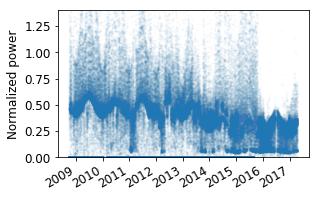

In [3]:
meta = {"altitude":0,
       "latitude": -23.761878,
       "longitude": 133.874846,
       "Name": "Alice Springs",
       "State": "n/a",
       "TZ": 8.5}

pv = pvlib.pvsystem.systemdef(meta, -10, 0, albedo=0.2, modules_per_string=7, strings_per_inverter=5)


pvwatts_kws = {"poa_global" : df['ghor'],
              "P_ref" : 10.5,
              "T_cell" : df['tamb'],
              "G_ref" : 1000,
              "T_ref": 25,
              "gamma_pdc" : -0.0041}

normalized = rdtools.normalize_with_pvwatts(df['ac power'], pvwatts_kws)


# Plot the normalized power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', alpha = 0.05)
ax.set_ylim(0,1.4)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

# 3. <b>Filter</b> 

Data filtering is used to exclude data points that represent invalid data, create bias in the analysis, or introduce significant noise.


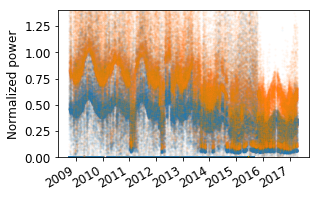

In [19]:
# Perform rudimetary filtering, more advanced filtering will be integrated
# into Rdtools in the future
filtered = normalized[(normalized > 0) & (normalized < 20)]


#after filtering, center the data at PR_t0 = 1
def center_data(series):
    v = series.resample('12M').median().max()    
    return series / v

filtered = center_data(filtered)


# Plot the normalized and filtered power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', alpha = 0.05)
ax.plot(filtered.index, filtered, 'o', alpha = 0.05)
ax.set_ylim(0,1.4)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');


# 4. <b>Analyze</b>

Data is then analyzed to estimate the degradation rate representing the PV system behavior.  The data may or may not be aggregated by this step.  

The degradation rate results for this system may include system issues due to tracker downtime. For more information see: http://dkasolarcentre.com.au/source/alice-springs/dka-m3-b-phase


In [ ]:
ols = rdtools.degradation.degradation_ols(filtered)
print "degradation_ols", ols

yoy = rdtools.degradation.degradation_year_on_year(filtered)
print "degradation_year_on_year", yoy